# Building Production Video Search with ClipTagger-12B: Semantic Understanding at 15x Lower Cost

Video understanding at scale used to cost millions. We just changed that.

Processing a billion frames with top models costs 3-6 million. With ClipTagger-12B, it's about $335,000 USD. We built this model to make video search affordable, and it's already running at scale with partners processing huge amounts of previously unsearchable content.

This tutorial walks through building a similar production video search system to what our enterprise customers use. You'll build a semantic search engine that understands natural language queries like "people sitting on couches" or "outdoor scenes with text overlays" across your entire video library. It will be able to filter by objects in the video, or actions taken, production quality, or any of the metadata generated by the model. The complete implementation runs in <300 lines of Python and costs less than 35c per thousand frames. This is especially useful for finding relevant clips in an era of AI video editing.

## Why ClipTagger-12B Changes Frame Captioning

Here's what it costs to process 1 million video frames (about 9 hours at 30fps):

- **GPT-4.1**: $5,100
- **Claude 4 Sonnet**: $5,850  
- **ClipTagger-12B**: $335

That 17x cost reduction over Sonnet cuts no corners: we get better caption quality than Sonnet and about as good as 4.1. ClipTagger-12B was trained specifically for video understanding, outputting structured JSON with consistent schema.

Note: this model outputs captions in a fixed schema. If you want to supply your own schema and use an arbitrary model, check out the short example notebook: [Video Captioning With VLMs](../video-captioning/video-captioning.ipynb)

## Setting Up Your Environment

We'll start with a minimal setup.

In [ ]:
!pip -q install --upgrade openai chromadb pydantic pillow matplotlib opencv-python-headless requests tqdm

The dependencies are intentionally minimal. We're using the OpenAI client to interact with the serverless Inference.net API (the model is OS so you can run it yourself as well), ChromaDB for vector storage, and standard computer vision libraries.

We use Chroma here for convenience, but the specific vector database you use is dependant on your scale and metadata filters that you require. If you are building a search index, contact us at partners@inference.net and we'll support you.

Now let's import everything and initialize our client:

In [2]:
import os
import json
import base64
import tempfile
import requests
from typing import List, Dict, Any, Tuple

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from pydantic import BaseModel, conlist

import chromadb
from openai import OpenAI

# Initialize client
client = OpenAI(
    base_url="https://api.inference.net/v1",
    api_key=os.getenv("INFERENCE_API_KEY")
)

If you're already using OpenAI in production, switching to ClipTagger-12B is a one-line configuration change. We maintain full compatibility while delivering massive cost savings.

## Defining the Output Schema

ClipTagger-12B outputs structured data following a specific schema. This consistency is what makes it so powerful for building searchable systems:

In [3]:
class ClipTaggerResponse(BaseModel):
    """Schema for structured video frame analysis"""
    description: str
    objects: conlist(str, max_length=10)
    actions: conlist(str, max_length=5)
    environment: str
    content_type: str
    specific_style: str
    production_quality: str
    summary: str
    logos: List[str]

 Each field serves a specific purpose:
- `description`: Rich semantic understanding for natural language search
- `objects`: What's in the frame (products, people, items)
- `actions`: What's happening (walking, talking, driving)
- `environment`: Where it's happening (office, outdoors, studio)
- `content_type`: Real footage vs animation vs CGI
- `specific_style`: Documentary, vlog, commercial, etc.
- `production_quality`: Professional vs amateur vs broadcast
- `summary`: One-line description for quick scanning
- `logos`: Brand detection for compliance and verification

This schema wasn't arbitrary. It was developed in partnership with Wynd to search their petabyte scale video library, and includes minimum viable fields for comprehensive video understanding.

## Downloading Sample Video

For this demo, we'll use a public sample video. In production, you'd likely pull from S3 or your video storage:

In [4]:
def download_video(url: str) -> str:
    """Download video from URL to temporary file"""
    print(f"📥 Downloading video...")
    fd, path = tempfile.mkstemp(suffix=".mp4")
    os.close(fd)

    with requests.get(url, stream=True, timeout=60) as r:
        r.raise_for_status()
        total_size = int(r.headers.get('content-length', 0))

        with open(path, "wb") as f:
            with tqdm(total=total_size, unit='B', unit_scale=True) as pbar:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
                        pbar.update(len(chunk))

    print(f"✅ Video saved to: {path}")
    return path

# Example: Download a sample video
VIDEO_URL = "https://commondatastorage.googleapis.com/gtv-videos-bucket/sample/ForBiggerFun.mp4"
video_path = download_video(VIDEO_URL)

📥 Downloading video...


100%|██████████| 12.9M/12.9M [00:00<00:00, 21.5MB/s]

✅ Video saved to: /var/folders/kt/hdh2gbcn6w77kyck8t4syphc0000gn/T/tmpj6fr9m6w.mp4


## Intelligent Frame Extraction

A 30fps video contains 1,800 frames per minute. Processing every frame would be wasteful since consecutive frames are nearly identical. Instead, we sample frames at strategic intervals:

In [ ]:
# %% Cell 6: Extract frames every N seconds
def extract_frames_every_n_seconds(video_path: str, interval_seconds: float = 20.0) -> List[Dict]:
    """Extract frames at regular time intervals"""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")

    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps

    print(f"📹 Video info: {duration:.1f}s duration, {fps:.1f} fps")

    frames = []
    current_time = 0

    while current_time < duration:
        frame_number = int(current_time * fps)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()

        if ret:
            frames.append({
                'image': frame,
                'frame_number': frame_number,
                'timestamp': current_time
            })
            print(f"  Extracted frame at {current_time:.1f}s")

        current_time += interval_seconds

    cap.release()
    print(f"✅ Extracted {len(frames)} frames")
    return frames

# Extract frames every 20 seconds
frames = extract_frames_every_n_seconds(video_path, interval_seconds=2.0)

We're extracting frames every 2 seconds for this demo. In production, you'd tune this based on content type:
- Fast action (sports, music videos): 0.5-1 second intervals
- Talking heads (interviews, tutorials): 10-30 second intervals  
- Security footage: 5-10 second intervals
- Film/TV content: 2-5 second intervals

The interval is your biggest cost optimization lever. Doubling the interval halves your costs.

You may want to limit the number of images per video or take a uniform number of images regardless of video length, as you might have an LLM summarization/processing step at the end. A 2 second interval is somewhat arbitrary and was chosen to make this sample more convenient.

Let's visualize what we extracted to verify our sampling strategy:

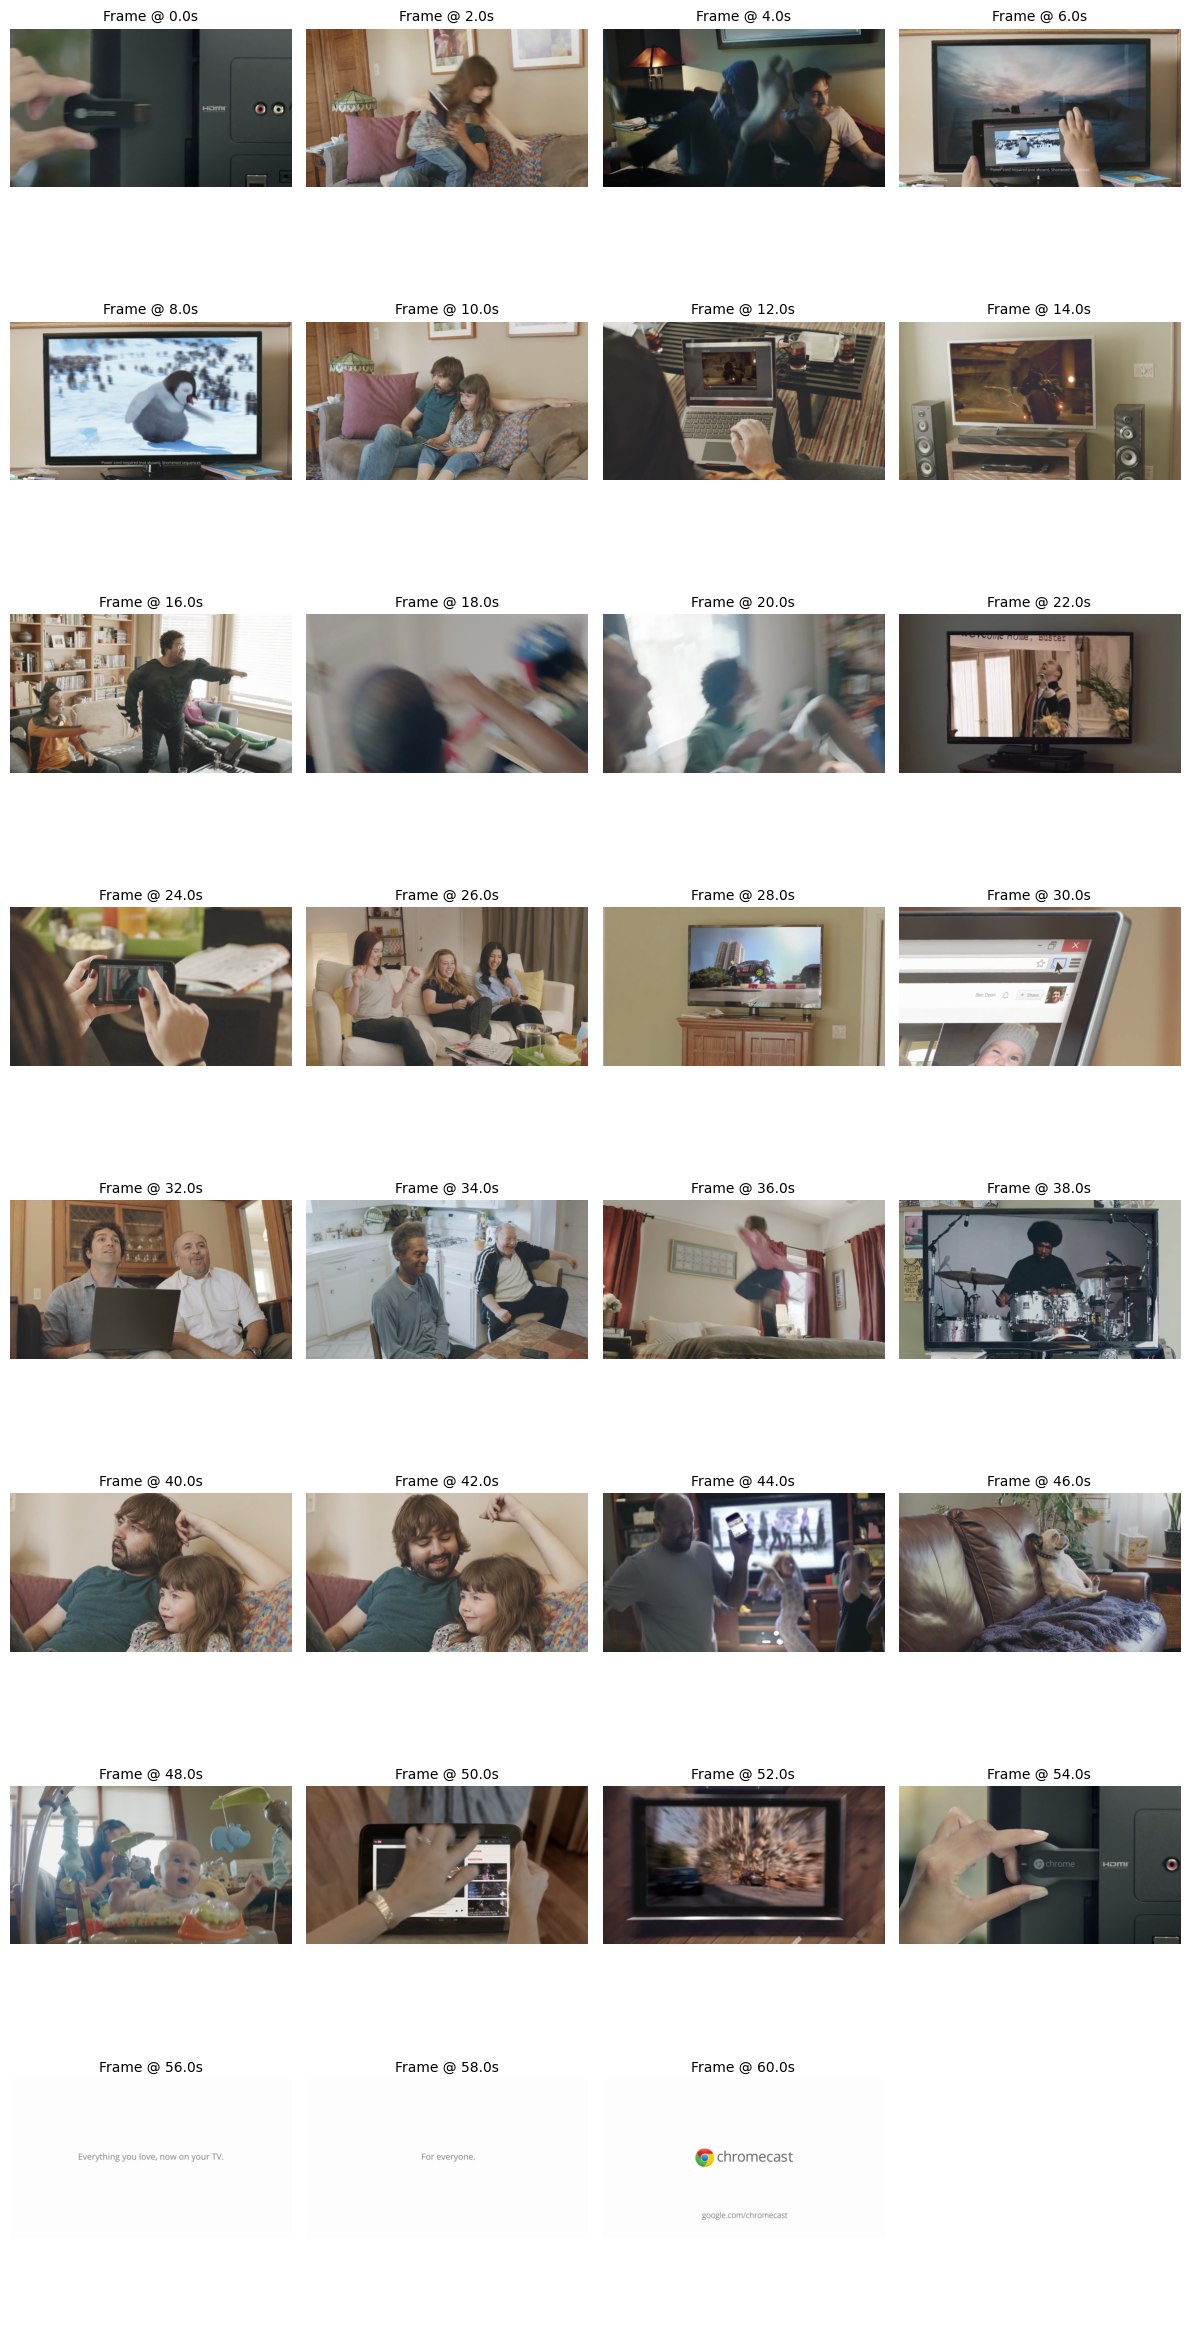

In [8]:
def show_frames(frames: List[Dict], max_cols: int = 4):
    """Display extracted frames in a grid"""
    n_frames = len(frames)
    n_cols = min(n_frames, max_cols)
    n_rows = (n_frames + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
    if n_frames == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_rows > 1 else axes

    for i, frame_data in enumerate(frames):
        ax = axes[i] if n_frames > 1 else axes[0]
        img_rgb = cv2.cvtColor(frame_data['image'], cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.set_title(f"Frame @ {frame_data['timestamp']:.1f}s", fontsize=10)
        ax.axis('off')

    # Hide empty subplots
    for i in range(n_frames, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_frames(frames)

This grid visualization helps validate your extraction strategy. Are you capturing scene changes? Are there redundant frames? In production, you might use scene detection algorithms to extract frames only when content changes significantly.

## Optimizing Frames for API Transmission

Before sending frames to the API, we need to prepare them efficiently. Many implementations waste bandwidth sending uncompressed 4K frames:

In [9]:
def frame_to_base64(frame: np.ndarray, max_width: int = 720) -> str:
    """Convert frame to base64-encoded JPEG"""
    h, w = frame.shape[:2]

    # Resize if too large
    if w > max_width:
        scale = max_width / w
        new_w = max_width
        new_h = int(h * scale)
        frame = cv2.resize(frame, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Encode as JPEG
    _, buffer = cv2.imencode('.jpg', frame, [cv2.IMWRITE_JPEG_QUALITY, 85])

    # Convert to base64
    return base64.b64encode(buffer).decode('utf-8')

Two critical optimizations happening here:

1. **Resolution capping at 720p**: ClipTagger-12B doesn't need 4K resolution. 720p provides excellent accuracy while reducing payload size by 5-10x.
2. **JPEG quality 85**: Imperceptible quality loss with 40% smaller files. You may want to experiment with WebP and other file types as well. You also don't need to use base64 and can send the raw image urls as well through the serverless API.

Combined, these optimizations can significantly reduce your API costs and latency compared to sending raw frames.

## Parallel Frame Processing

Now we caption all frames in parallel. This is where ClipTagger-12B's speed and consistency shine:

In [11]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import json
import pandas as pd

SYSTEM_PROMPT = """You are an image annotation API trained to analyze video keyframes.
You will be given instructions on the output format, what to caption, and how to perform your job.
Follow those instructions. For descriptions and summaries, provide them directly and do not lead them with
'This image shows' or 'This keyframe displays...', just get right into the details."""

USER_PROMPT = """Analyze this video frame and return a JSON object with these exact fields:

{
    "description": "Detailed factual account of what's visible (4 sentences max)",
    "objects": ["list of visible objects with details"],
    "actions": ["list of visible actions"],
    "environment": "Description of the setting",
    "content_type": "Type like 'real-world footage', 'animation', 'CGI', etc",
    "specific_style": "Genre/aesthetic like 'vlog', 'documentary', 'tutorial', etc",
    "production_quality": "Like 'professional', 'amateur', 'TV broadcast', etc",
    "summary": "One sentence summary",
    "logos": ["any visible logos"]
}

Be specific and literal. Focus only on what is explicitly visible.
Maximum 10 objects and 5 actions. Return only valid JSON."""

def caption_single_frame(frame_data, index):
    base64_image = frame_to_base64(frame_data['image'])

    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": [
            {"type": "text", "text": USER_PROMPT},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}", "detail": "high"}}
        ]}
    ]

    response = client.chat.completions.create(
        model="inference-net/cliptagger-12b",
        messages=messages,
        temperature=0.1,
        max_tokens=2000,
        response_format={"type": "json_object"}  # THIS FORCES VALID JSON
    )

    result_json = json.loads(response.choices[0].message.content)
    return index, result_json, base64_image

# Run in parallel
results = [None] * len(frames)
with ThreadPoolExecutor(max_workers=20) as executor:
    futures = {executor.submit(caption_single_frame, frame, i): i for i, frame in enumerate(frames)}

    for future in tqdm(as_completed(futures), total=len(frames), desc="Captioning frames"):
        index, caption, base64_img = future.result()
        results[index] = {
            'timestamp': frames[index]['timestamp'],
            'frame_number': frames[index]['frame_number'],
            **caption,
            'base64': base64_img
        }

# Convert to DataFrame
df = pd.DataFrame(results)
print(f"✅ Captioned {len(df)} frames")
df.head()

Captioning frames: 100%|██████████| 31/31 [00:12<00:00,  2.57it/s]

✅ Captioned 31 frames


timestamp  frame_number                                            actions  \
0        0.0             0  [A person holding a streaming device, A person...   
1        2.0            47  [A person holding a child on their lap., A chi...   
2        4.0            95  [A person in a hoodie raising their hand towar...   
3        6.0           143  [A person watching a video on a television., A...   
4        8.0           191  [Displaying an image on a screen, Standing in ...   

         content_type                                        description  \
0  real-world footage  A person's hand holds a black streaming device...   
1  real-world footage  A person wearing a green shirt and jeans sits ...   
2  real-world footage  In a dimly lit room, a person wearing a blue h...   
3  real-world footage  A person's hands are visible in front of a lar...   
4  real-world footage  A television screen displays an image of a lar...   

                                         environment  \
0  A close-up view of the back of an electronic d...   
1  The interior of a living room with beige walls...   
2  A dimly lit interior room, likely a living roo...   
3  An indoor setting, likely a living room, with ...   
4  An indoor setting, likely a living room or bed...   

                                               logos  \
0  [VIZIO logo in white text, Google Chrome logo,...   
1                                                 []   
2                                                 []   
3                                                 []   
4                                                 []   

                                             objects production_quality  \
0  [Human hand, Streaming device, black with a wh...       professional   
1  [Person in a green shirt, Child with long brow...            amateur   
2  [Person in a blue hoodie, Man in a light-color...       professional   
3  [Television screen, Tablet, Human hands, Pengu...       professional   
4  [Television screen, Penguins, Snow, English te...            amateur   

    specific_style                                            summary  \
0         tutorial  A person's hand plugs a black streaming device...   
1       home video  A person holds a child on their lap on a couch...   
2  cinematic scene  In a dimly lit room, a person in a blue hoodie...   
3       Commercial  A person holds a tablet in front of a large te...   
4             vlog  A television screen in a room displays an imag...   

                                              base64  
0  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUDBAQEAwUEBA...  
1  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUDBAQEAwUEBA...  
2  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUDBAQEAwUEBA...  
3  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUDBAQEAwUEBA...  
4  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUDBAQEAwUEBA...

Here we use 20 parallel workers to send async requests in parallel. This is great for getting started with the model or working with it if you're running it yourself. But in production, often you don't need instant results. 

We built a [Group API](https://docs.inference.net/features/asynchronous-inference/group#1-submit-a-group-request) specifically for this model to send requests in small batches of up to 50. This is great because you get a discount for using background compute, get more reliable processing, and don't have to wait for responses. You can use this with polling, but we highly recommend you use a webhook workflow, where you send a request with all the frames of a particular video, then wait for your webhook to recieve the response to process it and upsert you database.

The exact workflow you use is up to you, but we find the Group API to be superior for large scale video processing in most cases.

The model is understanding scenes, identifying production techniques, detecting brands, and providing rich semantic descriptions. This structured data becomes the foundation for powerful search capabilities.

## Building the Vector Search Index

Now we make this data searchable using ChromaDB, an embedded vector database. Let's intialize a Chroma client and create a collection:

In [13]:
import chromadb

chroma_client = chromadb.EphemeralClient()
collection = chroma_client.create_collection(name="video_frames")

ChromaDB handles the complexity of vector indexing and similarity search. In production you'll use a persistant vector store, but here we're using an Ephemeral Client for convenience. In production you may also want to choose an embedding model that isn't the one Chroma uses as the default.

The beauty with Cliptagger is that you can do many things unoptimally and still end up with pretty good frame search.

In [14]:
ids = [f"frame_{i}" for i in range(len(df))]
documents = [row['description'] for _, row in df.iterrows()]
metadatas = [
   {
       'timestamp': row['timestamp'],
       'frame_number': row['frame_number'],
       'content_type': row['content_type'],
       'specific_style': row['specific_style'],
       'production_quality': row['production_quality'],
       'environment': row['environment'],
       'logos': str(row['logos']),  # Convert to string
       'objects': str(row['objects']),  # Convert to string
       'actions': str(row['actions'])  # Convert to string
   }
   for _, row in df.iterrows()
]

collection.add(
    ids=ids,
    documents=documents,
    metadatas=metadatas
)

print(f"✅ Added {collection.count()} frames to Chroma")

✅ Added 31 frames to Chroma


We have now stored all of our frames in our vector store!

The architecture here is important: we're indexing the rich `description` field for semantic search while storing all structured metadata for filtering. This dual approach enables both natural language queries and precise attribute filtering.

We're storing logos, objects, and actions as strings which isn't ideal, and this is something you can definitely improve upon. We also may want to have multiple indexes in production: we might index not only on the description but on several other fields as well.

## Visualizing Search Results

Before we start searching, let's build a helper to visualize results:

In [15]:
def show_results(results, frames, title="Search Results"):
   n_results = len(results['ids'][0])
   if n_results == 0:
       print("No results found")
       return

   fig, axes = plt.subplots(1, n_results, figsize=(4*n_results, 4))
   if n_results == 1:
       axes = [axes]

   for i, frame_id in enumerate(results['ids'][0]):
       frame_idx = int(frame_id.split('_')[1])
       frame = frames[frame_idx]['image']
       meta = results['metadatas'][0][i]

       axes[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
       axes[i].set_title(f"{meta['timestamp']:.1f}s | {meta.get('content_type', 'N/A')}\n{results['documents'][0][i][:60]}...", fontsize=9)
       axes[i].axis('off')

   fig.suptitle(title, fontsize=12)
   plt.tight_layout()
   plt.show()

This function displays the actual frames with their timestamps and descriptions.

## Natural Language Video Search

We are now ready to search our video with natural language:

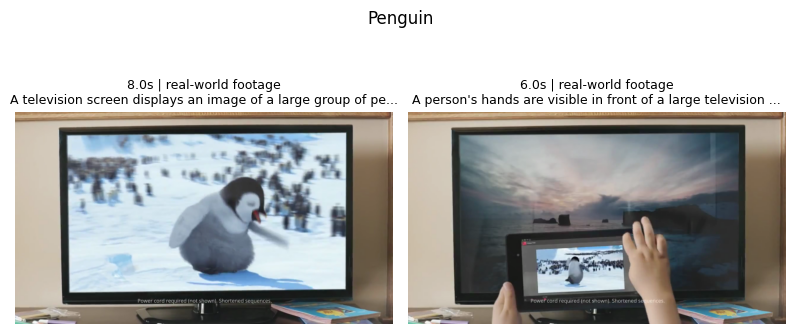

In [16]:
results = collection.query(
    query_texts=["penguin"],
    n_results=2
)
show_results(results, frames, "Penguin")

We were able to find every frame that has a penguin! Good search systems combine vector search with keyword search algorithms like BM25 and possibly even reranking. But even this simple vector search was able to find what we were looking for.

Let's combine semantic search with metadata filtering:

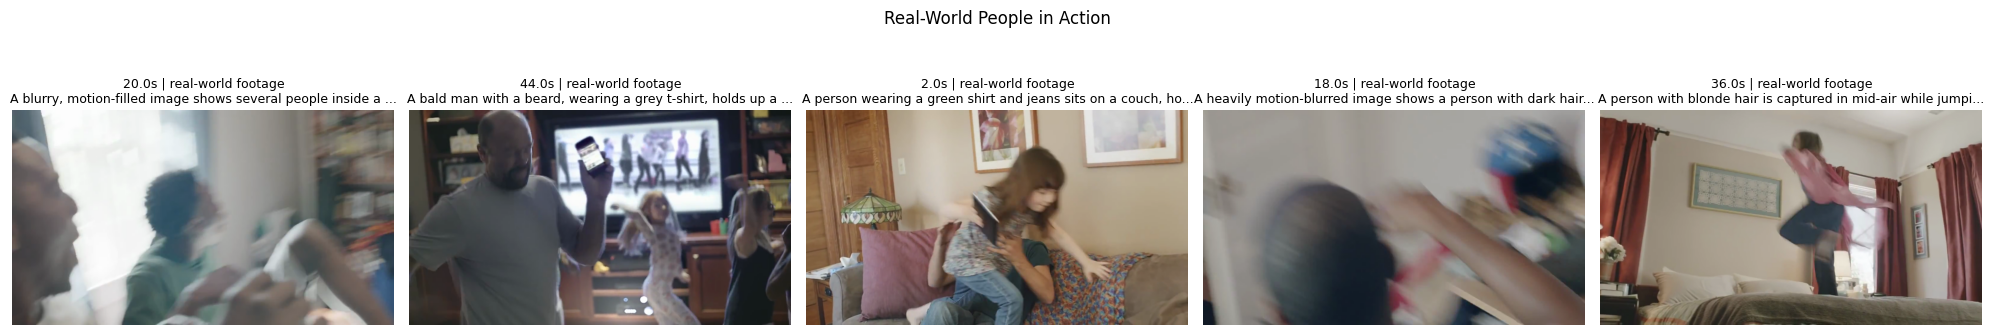

In [17]:
results = collection.query(
    query_texts=["people moving or doing activities"],
    where={"content_type": "real-world footage"},
    n_results=5
)
show_results(results, frames, "Real-World People in Action")

This query finds frames where people appear to be moving but filters out all frames that don't appear to be real-world footage. The ability to use metadata-filters like this is a serious advantage of this model's output schema.

More complex scene composition queries:

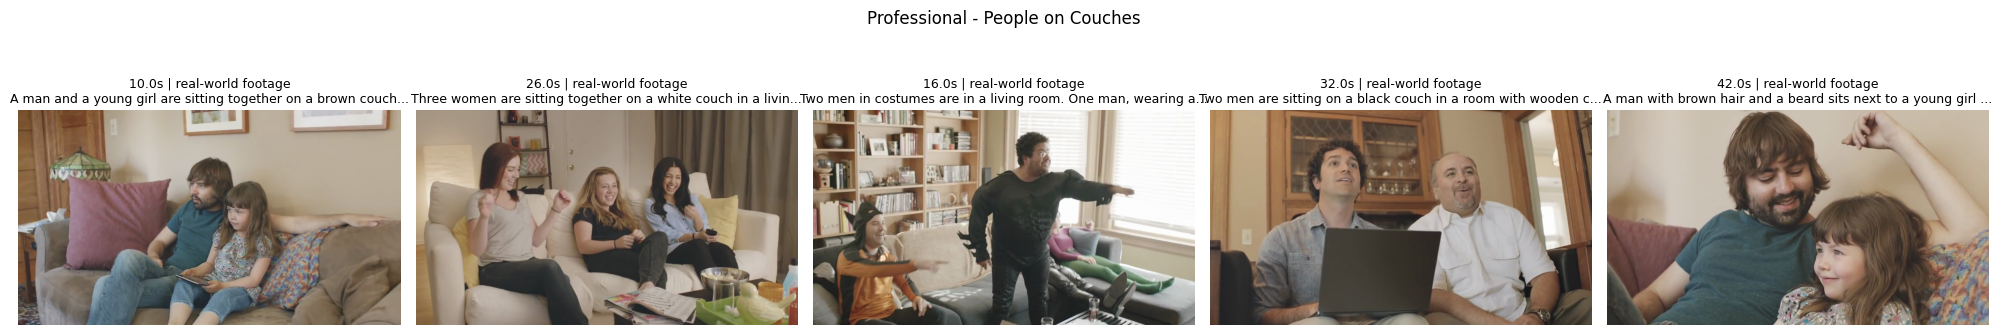

In [18]:
results = collection.query(
    query_texts=["people sitting together on couch"],
    where={"production_quality": "professional"},
    n_results=5
)
show_results(results, frames, "Professional - People on Couches")

Video editors make queries like this hundreds of times daily when searching for B-roll or specific shots. Through the generated metadata, we can create more sophisticated queries for the exact scene composition that we need.

Finding text overlays and graphics:

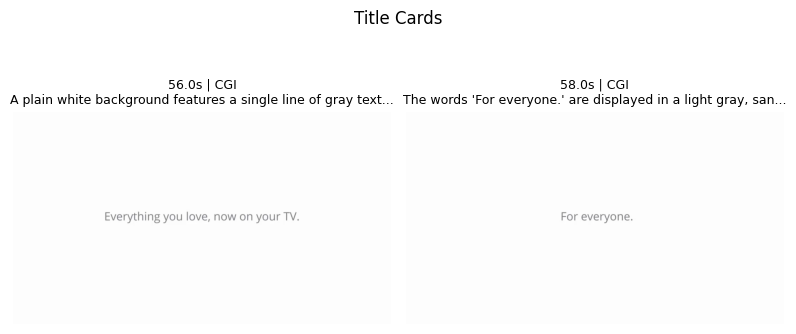

In [ ]:
results = collection.query(
    query_texts=["text overlay or title card"],
    n_results=2
)
show_results(results, frames, "Title Cards")

Text overlays are traditionally difficult for computer vision systems. With ClipTagger-12B, finding them is trivial.

Finally, let's use the structured metadata for brand detection:

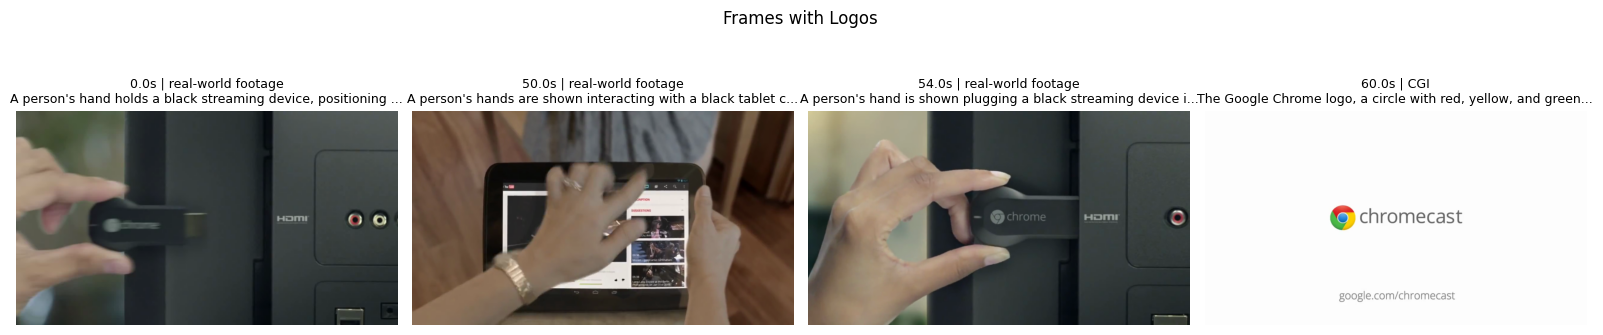

Frame at 0.0s: ['VIZIO logo in white text', 'Google Chrome logo, a white circle with a red dot, on the streaming device']
Frame at 50.0s: ['YouTube logo, a red rectangle with a white play button icon, in the top left corner of the tablet screen.']
Frame at 54.0s: ['Google Chrome logo, a circle with red, yellow, and green sections and a blue circle in the center.', "HDMI logo, the letters 'HDMI' in a white, sans-serif font."]
Frame at 60.0s: ['Google Chrome logo, a circle with red, yellow, and green sections and a blue center.']


In [20]:
results = collection.get(
    where={"logos": {"$ne": "[]"}},
    limit=10
)

query_results = {
    'ids': [results['ids']],
    'documents': [results['documents']],
    'metadatas': [results['metadatas']]
}
show_results(query_results, frames, "Frames with Logos")

# Print logo details
for meta in results['metadatas']:
    if meta['logos'] != '[]':
        print(f"Frame at {meta['timestamp']}s: {meta['logos']}")

Automatic logo detection is invaluable for brand safety, placement verification, and compliance. ClipTagger-12B comes with logo detection out of the box.

## Bottom Line

ClipTagger-12B makes comprehensive video understanding economically viable for everyone. At 15x+ lower cost than frontier models, you can finally build the video search experiences that were previously limited to tech giants.

The code in this sample is a reference implementation matching patterns used in production deployments processing billions of frames monthly. The difference between this demo and production is largely scale -- ClipTagger-12B scales linearly from one frame to one billion.

It's also possible that the schema you need doesn't match the one outputed by ClipTagger. In that case, it might make more sense to work with us to train a custom model.

## Start Building Today

Get your API key: [inference.net/register](https://inference.net/register) — \$25 in free credits.

Resources: [Blog](https://inference.net/blog/cliptagger-12b) · [Model card (Hugging Face)](https://huggingface.co/inference-net/ClipTagger-12b) · [API model page](https://inference.net/models/cliptagger-12b)

For production deployments or custom training, reach out to [partners@inference.net](mailto:partners@inference.net).


---

*Want custom model training? We deliver production models in 30 days. Contact [partners@inference.net](mailto:partners@inference.net).*
